In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [32]:

df = sm.datasets.macrodata.load_pandas().data

# Функція для створення дати з року та кварталу
def create_date(row):
    return pd.Timestamp(year=int(row['year']), month=int(row['quarter'] * 3 - 2), day=1)

df['date'] = df.apply(create_date, axis=1)
year = df.drop_duplicates("year")
year = df

X = df[['realgdp', 'realcons', 'realinv', 'realgovt',
        'realdpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values
# X = df[['realgdp', 'realcons', 'realinv', 'realgovt']].values 
y = df['cpi'].values  # Цільова змінна

y = y.reshape(-1, 1)

In [33]:
from model import NeuralNetwork
from layers import DenseLayer
from optimizers import GeneticOptimizer
from activations import ReLU


model = NeuralNetwork(X.shape[1])
model.add_layer(DenseLayer(num_inputs=X.shape[1], num_neurons=8, activation_func=ReLU()))
model.add_layer(DenseLayer(num_inputs=8, num_neurons=1, activation_func=ReLU()))

# Налаштування оптимізатора
optimizer = GeneticOptimizer(population_size=50, mutation_rate=0.1)

# Навчання моделі
# history = model.fit(X, y, epochs=1000, optimizer=optimizer)


Training on window 1 (0-50)
Generation 0: Best fitness = -1052.8018970177168
Generation 100: Best fitness = -11.764508455398031
Generation 200: Best fitness = -4.6858852161589475
Generation 300: Best fitness = -2.612792532093936
Generation 400: Best fitness = -1.6922625959737936
Generation 500: Best fitness = -1.0544791311776658
Generation 600: Best fitness = -0.886019395859929
Generation 700: Best fitness = -0.8216813231420446
Generation 800: Best fitness = -0.7199083493463244
Generation 900: Best fitness = -0.6582929499241831


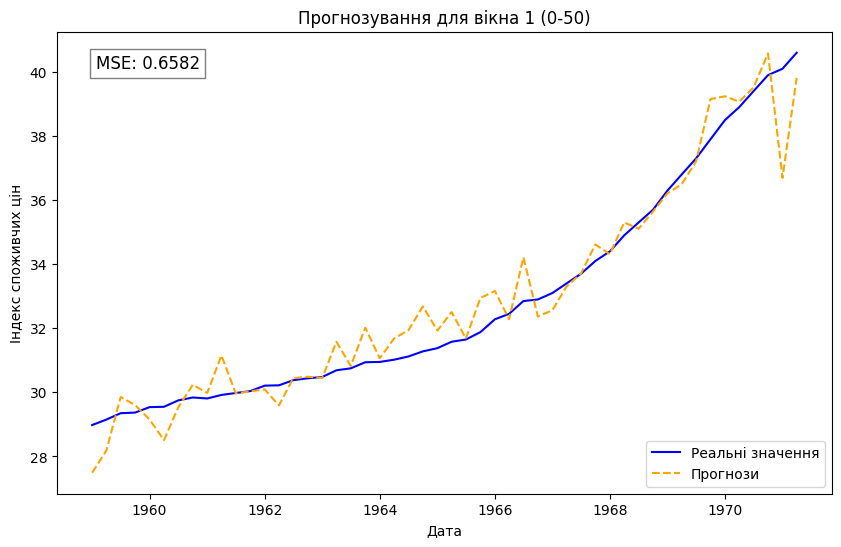

Training on window 2 (1-51)
Generation 0: Best fitness = -0.7634385821464281
Generation 100: Best fitness = -0.6506561037803695
Generation 200: Best fitness = -0.5671434603439692
Generation 300: Best fitness = -0.5638277966682114
Generation 400: Best fitness = -0.5347386117687957
Generation 500: Best fitness = -0.5301420613324406
Generation 600: Best fitness = -0.5036515233691917
Generation 700: Best fitness = -0.47727858558720326
Generation 800: Best fitness = -0.4681686385180195
Generation 900: Best fitness = -0.38789743055257103


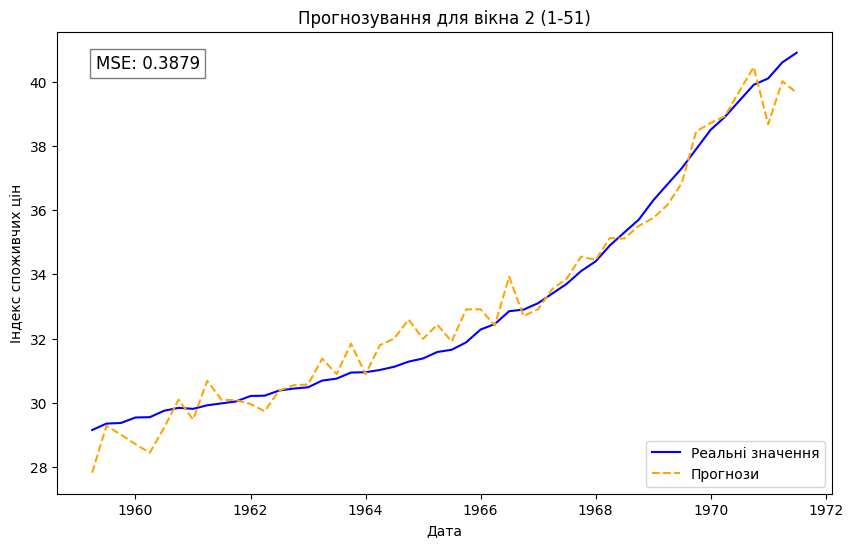

Training on window 3 (2-52)
Generation 0: Best fitness = -0.3749842680839807
Generation 100: Best fitness = -0.36042924235978896
Generation 200: Best fitness = -0.3491378169833586
Generation 300: Best fitness = -0.3491378169833586
Generation 400: Best fitness = -0.3377028637064764
Generation 500: Best fitness = -0.3377028637064764
Generation 600: Best fitness = -0.3377028637064764
Generation 700: Best fitness = -0.32217975465922527
Generation 800: Best fitness = -0.32217975465922527
Generation 900: Best fitness = -0.32217975465922527


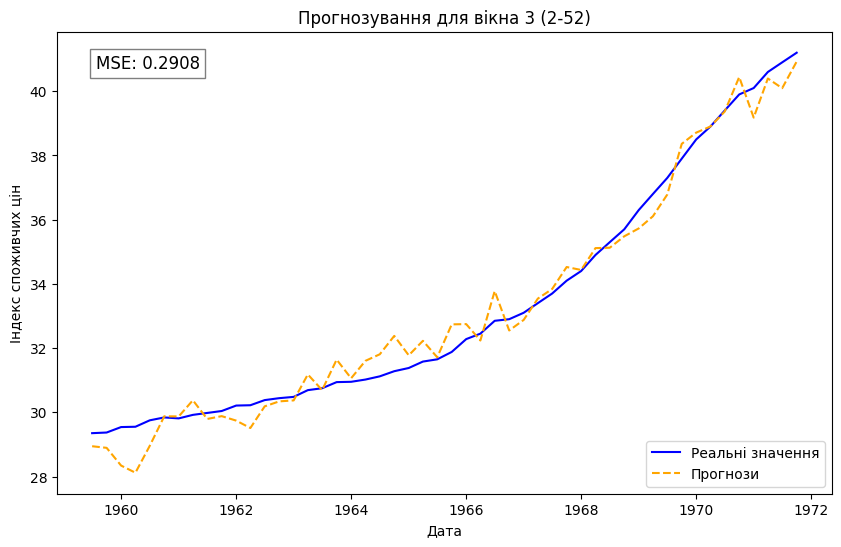

Training on window 4 (3-53)
Generation 0: Best fitness = -0.32748056805691506
Generation 100: Best fitness = -0.2908080448243513
Generation 200: Best fitness = -0.2908080448243513
Generation 300: Best fitness = -0.2840759940643867
Generation 400: Best fitness = -0.28285752392697344
Generation 500: Best fitness = -0.28285752392697344
Generation 600: Best fitness = -0.2721660880148357
Generation 700: Best fitness = -0.2721660880148357
Generation 800: Best fitness = -0.2709347652756917
Generation 900: Best fitness = -0.2709347652756917


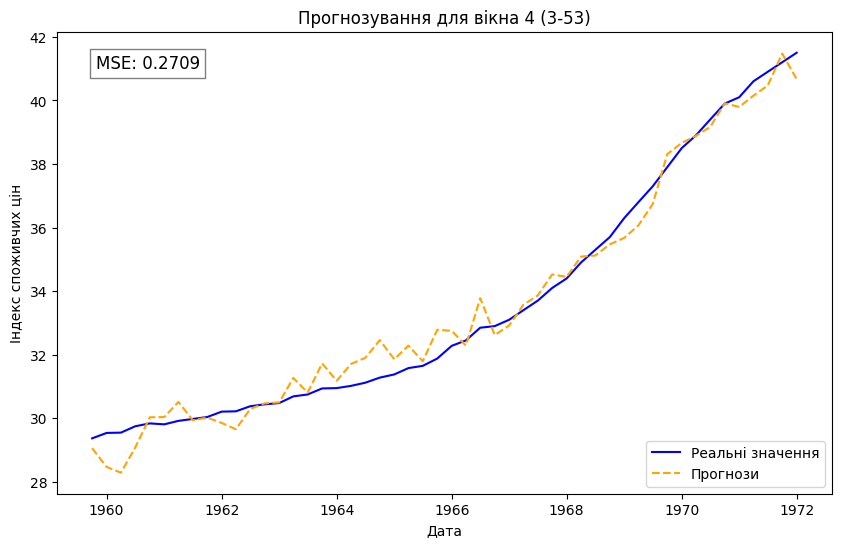

Training on window 5 (4-54)
Generation 0: Best fitness = -0.3124625994645921
Generation 100: Best fitness = -0.3014769330367578
Generation 200: Best fitness = -0.28108544662481294
Generation 300: Best fitness = -0.28108544662481294
Generation 400: Best fitness = -0.28108544662481294
Generation 500: Best fitness = -0.28108544662481294
Generation 600: Best fitness = -0.2770165111988377
Generation 700: Best fitness = -0.2770165111988377
Generation 800: Best fitness = -0.2680278038662752
Generation 900: Best fitness = -0.2680278038662752


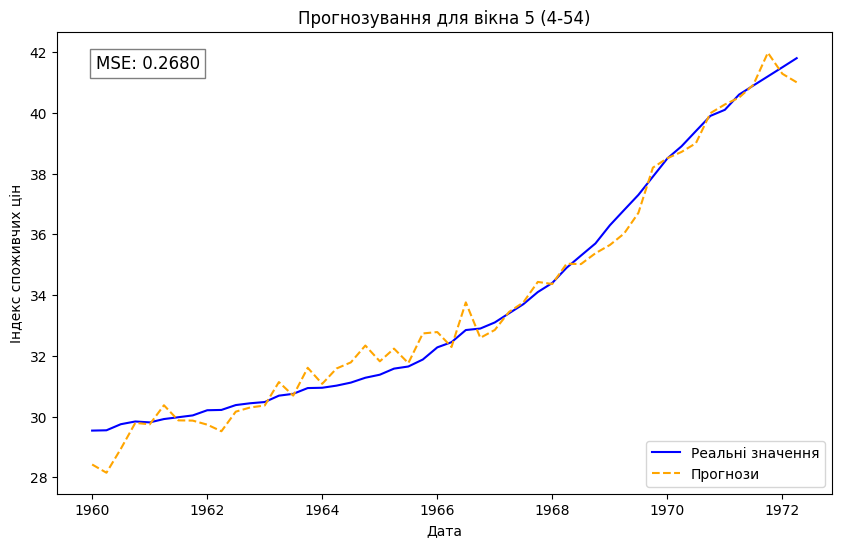

Training on window 6 (5-55)
Generation 0: Best fitness = -0.24651389487449776
Generation 100: Best fitness = -0.24536077293312475
Generation 200: Best fitness = -0.24531010218697394
Generation 300: Best fitness = -0.24531010218697394
Generation 400: Best fitness = -0.24531010218697394
Generation 500: Best fitness = -0.2424454448501685
Generation 600: Best fitness = -0.2424454448501685
Generation 700: Best fitness = -0.2424454448501685
Generation 800: Best fitness = -0.2415502238742831
Generation 900: Best fitness = -0.2415502238742831


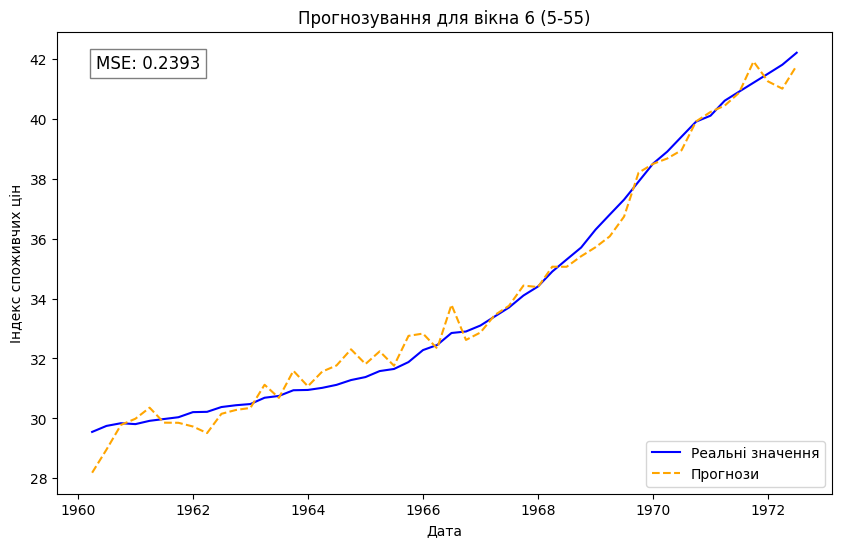

Training on window 7 (6-56)
Generation 0: Best fitness = -0.205022840160845
Generation 100: Best fitness = -0.20113875228995215
Generation 200: Best fitness = -0.197437729719117
Generation 300: Best fitness = -0.197437729719117
Generation 400: Best fitness = -0.19450071907617436
Generation 500: Best fitness = -0.19450071907617436
Generation 600: Best fitness = -0.19331681133966153
Generation 700: Best fitness = -0.19331681133966153
Generation 800: Best fitness = -0.19331681133966153
Generation 900: Best fitness = -0.19331681133966153


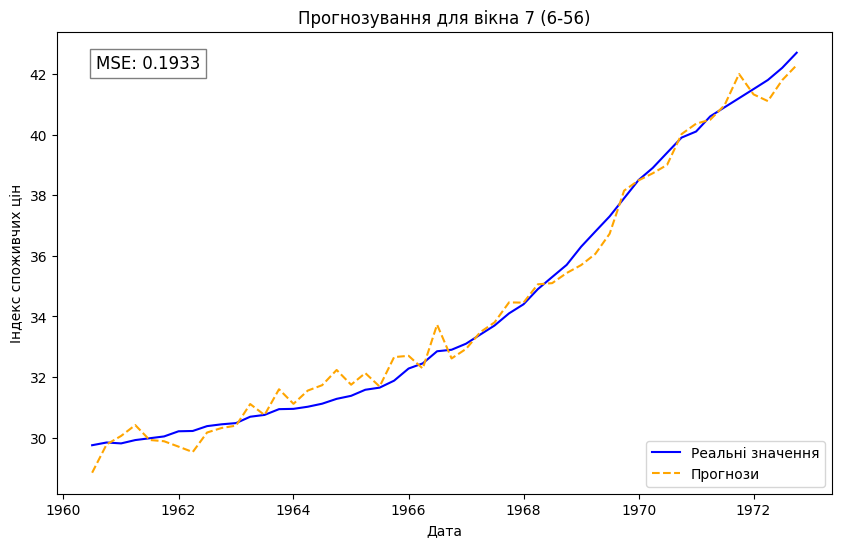

Training on window 8 (7-57)
Generation 0: Best fitness = -0.2605538929431106
Generation 100: Best fitness = -0.18851026951183666
Generation 200: Best fitness = -0.18851026951183666
Generation 300: Best fitness = -0.1851714562587798
Generation 400: Best fitness = -0.1851714562587798
Generation 500: Best fitness = -0.1851714562587798
Generation 600: Best fitness = -0.1699897085266674
Generation 700: Best fitness = -0.1699897085266674
Generation 800: Best fitness = -0.16769353600278958
Generation 900: Best fitness = -0.16769353600278958


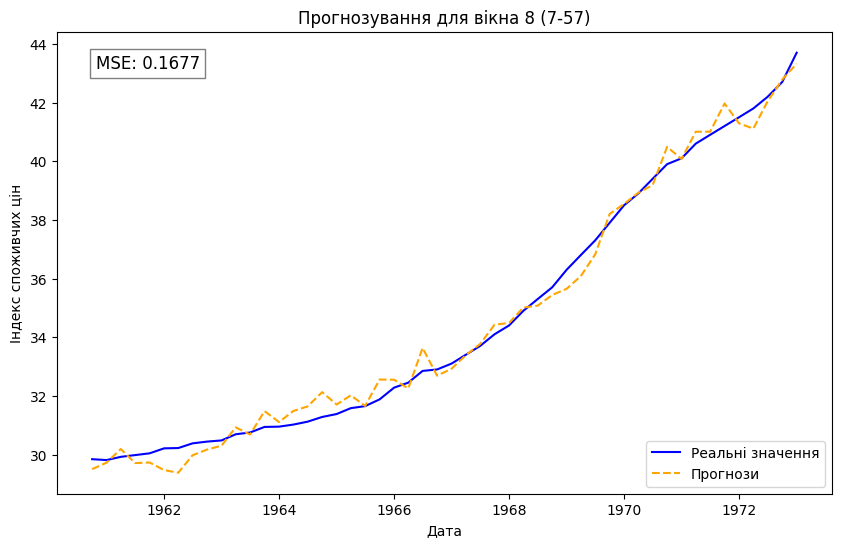

Training on window 9 (8-58)
Generation 0: Best fitness = -0.25453886547944576
Generation 100: Best fitness = -0.22562428271404514
Generation 200: Best fitness = -0.21367634594612878
Generation 300: Best fitness = -0.21367634594612878
Generation 400: Best fitness = -0.19621933753869436
Generation 500: Best fitness = -0.19621933753869436
Generation 600: Best fitness = -0.17133424600494798
Generation 700: Best fitness = -0.17133424600494798
Generation 800: Best fitness = -0.17133424600494798
Generation 900: Best fitness = -0.16847690828150091


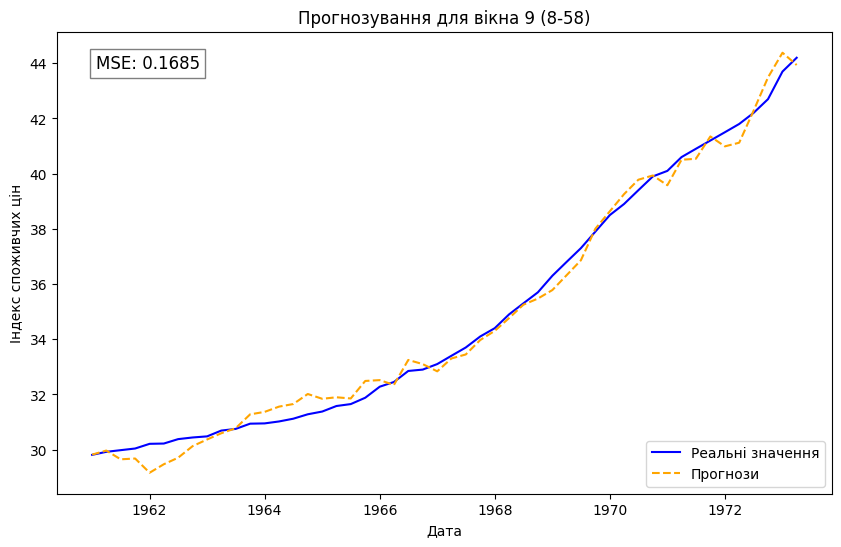

Training on window 10 (9-59)
Generation 0: Best fitness = -0.18584234391397178
Generation 100: Best fitness = -0.16948596710637032
Generation 200: Best fitness = -0.15844517711425757
Generation 300: Best fitness = -0.15844517711425757
Generation 400: Best fitness = -0.15485064994017483
Generation 500: Best fitness = -0.14903795575821527
Generation 600: Best fitness = -0.14137678601546427
Generation 700: Best fitness = -0.14137678601546427
Generation 800: Best fitness = -0.13952674766053566
Generation 900: Best fitness = -0.13952674766053566


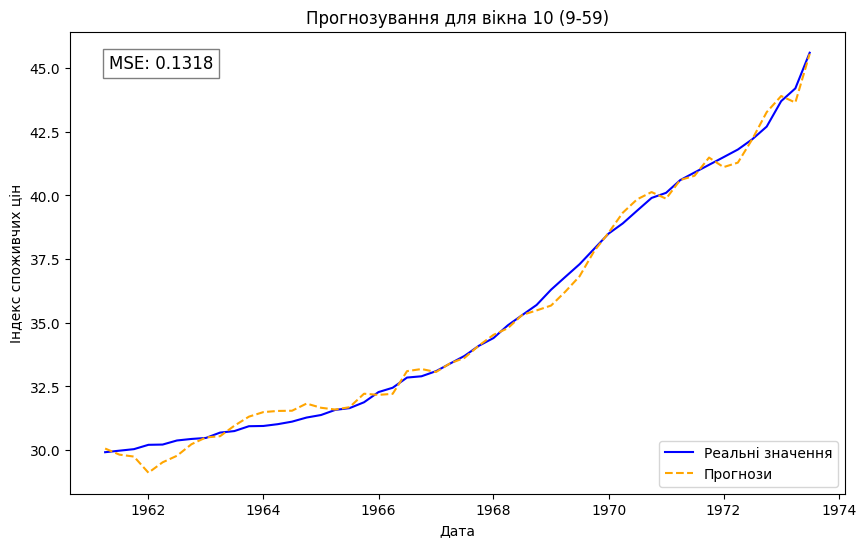

In [34]:
def sliding_window_training(X, y, folder, window_size=12, num_windows=10): 
    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        if end_index > len(X):
            print("End of data reached.")
            break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X[start_index:end_index] 
        y_window = y[start_index:end_index]

        # Навчання мережі на поточному вікні
        model.fit(X_window, y_window, epochs=1000, optimizer=optimizer)
        # Прогнозування 
        predictions = model.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'{folder}/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'{folder}/window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
sliding_window_training(X_scaled, y, "full", window_size=50, num_windows=10)

In [35]:
year_part = df.drop_duplicates("year")
# year = df

# X = year[['realgdp', 'realcons', 'realinv', 'realgovt',
#         'realdpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values
X_part = df[['realgdp', 'realcons', 'realinv', 'realgovt']].values 
y_part = df['cpi'].values  # Цільова змінна

y_part = y_part.reshape(-1, 1)

Training on window 1 (0-50)
Generation 0: Best fitness = -1088.403778
Generation 100: Best fitness = -23.704294963674123
Generation 200: Best fitness = -6.4649401726292695
Generation 300: Best fitness = -2.5712072040316842
Generation 400: Best fitness = -0.5361039340096145
Generation 500: Best fitness = -0.46861374952748475
Generation 600: Best fitness = -0.43608518864508455
Generation 700: Best fitness = -0.3937666864346631
Generation 800: Best fitness = -0.3937666864346631
Generation 900: Best fitness = -0.36972661760637765


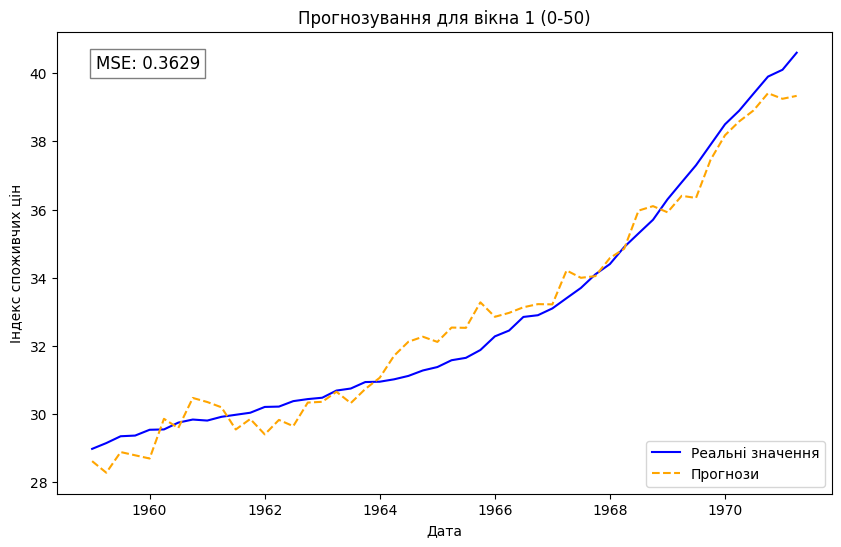

Training on window 2 (1-51)
Generation 0: Best fitness = -0.39581645356457357
Generation 100: Best fitness = -0.3568956190783619
Generation 200: Best fitness = -0.3468282829052554
Generation 300: Best fitness = -0.3258690801349486
Generation 400: Best fitness = -0.3258690801349486
Generation 500: Best fitness = -0.3258690801349486
Generation 600: Best fitness = -0.31734329218819424
Generation 700: Best fitness = -0.3049667069037952
Generation 800: Best fitness = -0.2964016568330924
Generation 900: Best fitness = -0.28856674819463524


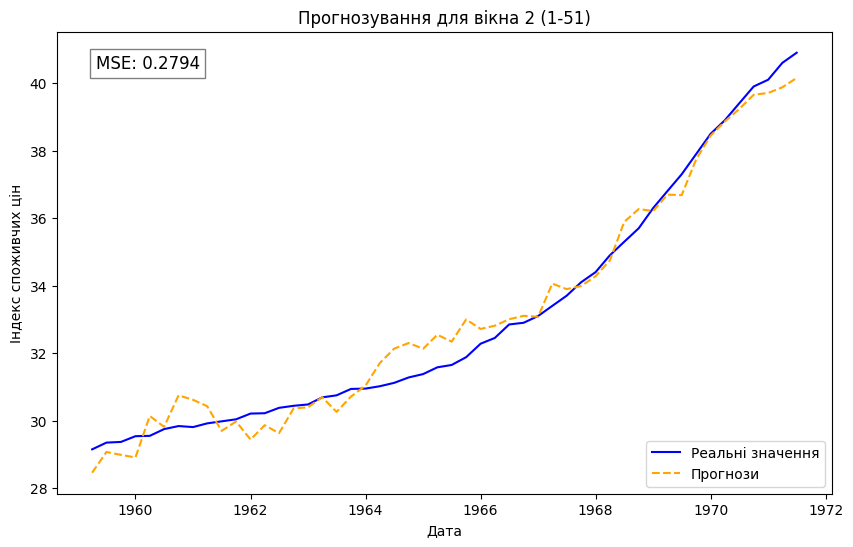

Training on window 3 (2-52)
Generation 0: Best fitness = -0.2706782171348797
Generation 100: Best fitness = -0.25415575370226134
Generation 200: Best fitness = -0.24995091471712677
Generation 300: Best fitness = -0.24556439208726835
Generation 400: Best fitness = -0.24403573541919518
Generation 500: Best fitness = -0.24103109286705557
Generation 600: Best fitness = -0.2373261815301741
Generation 700: Best fitness = -0.23306008246936016
Generation 800: Best fitness = -0.2308329513746222
Generation 900: Best fitness = -0.22944554428507394


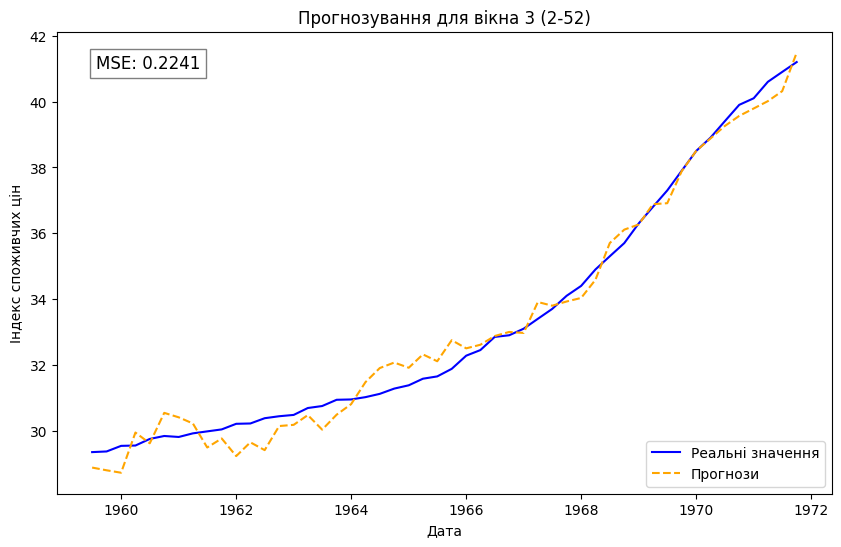

Training on window 4 (3-53)
Generation 0: Best fitness = -0.21978470395571667
Generation 100: Best fitness = -0.21333904927857092
Generation 200: Best fitness = -0.2025268189995057
Generation 300: Best fitness = -0.2025268189995057
Generation 400: Best fitness = -0.19884762864304414
Generation 500: Best fitness = -0.1957500276061135
Generation 600: Best fitness = -0.19450711287506287
Generation 700: Best fitness = -0.19329815448091398
Generation 800: Best fitness = -0.19031109386549588
Generation 900: Best fitness = -0.18515769111962077


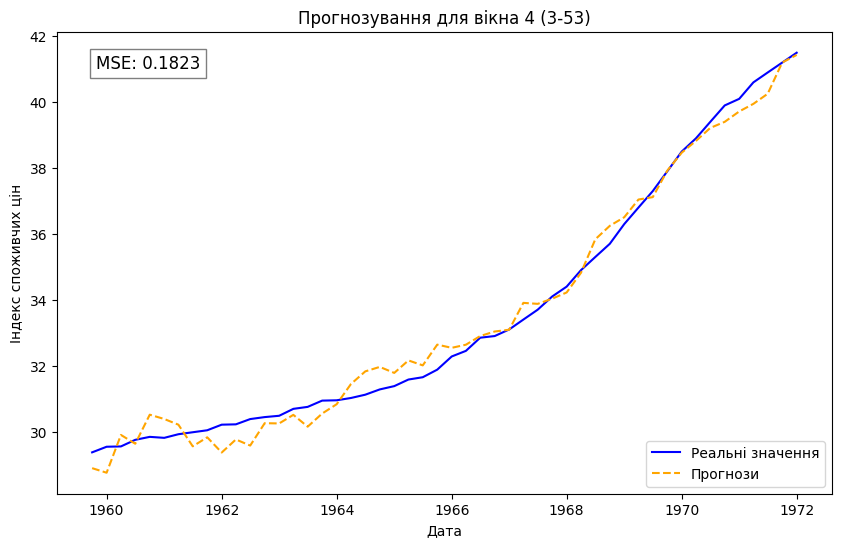

Training on window 5 (4-54)
Generation 0: Best fitness = -0.17829280401535666
Generation 100: Best fitness = -0.1714816875816811
Generation 200: Best fitness = -0.1714816875816811
Generation 300: Best fitness = -0.167563967655006
Generation 400: Best fitness = -0.167563967655006
Generation 500: Best fitness = -0.167563967655006
Generation 600: Best fitness = -0.16659335787745108
Generation 700: Best fitness = -0.16625391079643687
Generation 800: Best fitness = -0.15837940707376474
Generation 900: Best fitness = -0.15837940707376474


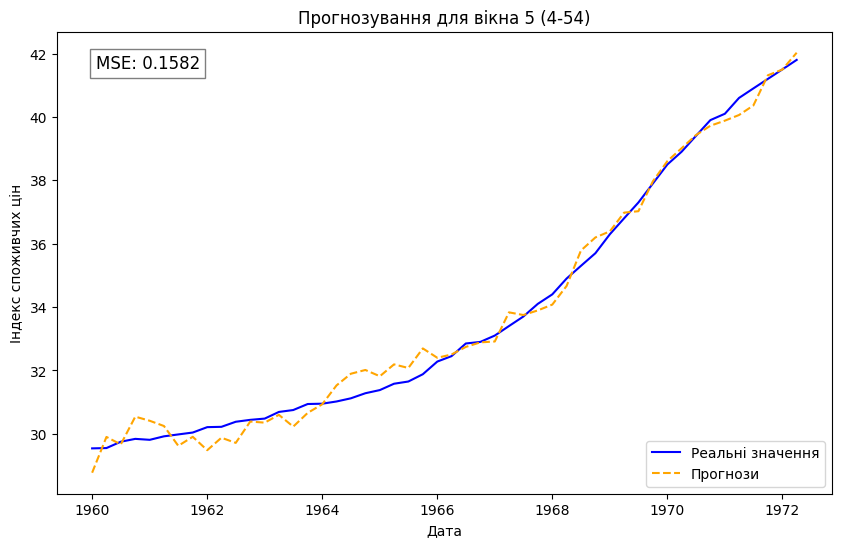

Training on window 6 (5-55)
Generation 0: Best fitness = -0.1510111652432752
Generation 100: Best fitness = -0.14436202793024908
Generation 200: Best fitness = -0.14044961433479541
Generation 300: Best fitness = -0.1403527178078043
Generation 400: Best fitness = -0.13733330577616645
Generation 500: Best fitness = -0.13681974691146195
Generation 600: Best fitness = -0.13454206518339115
Generation 700: Best fitness = -0.13435189189885388
Generation 800: Best fitness = -0.13220736286112117
Generation 900: Best fitness = -0.13121112008823854


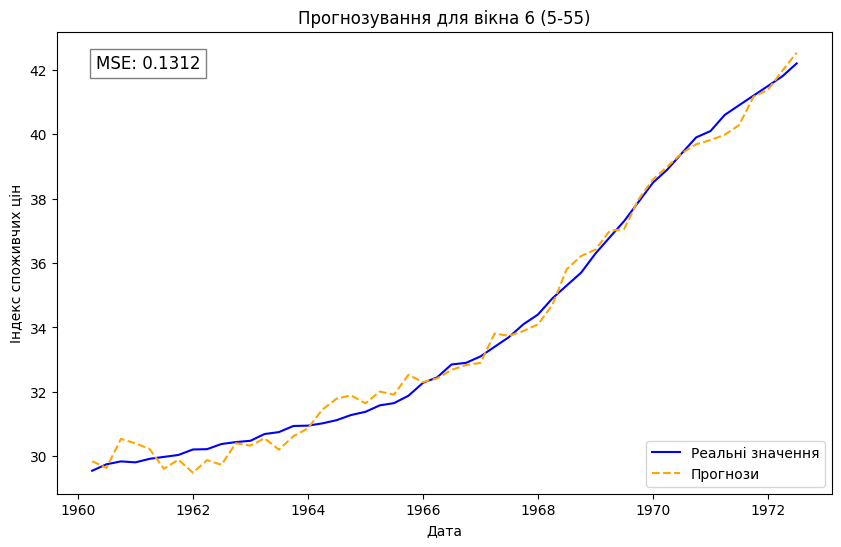

Training on window 7 (6-56)
Generation 0: Best fitness = -0.1482601294150989
Generation 100: Best fitness = -0.14600900336773506
Generation 200: Best fitness = -0.13582343421351514
Generation 300: Best fitness = -0.13582343421351514
Generation 400: Best fitness = -0.13582343421351514
Generation 500: Best fitness = -0.13582343421351514
Generation 600: Best fitness = -0.13582343421351514
Generation 700: Best fitness = -0.13582343421351514
Generation 800: Best fitness = -0.13582343421351514
Generation 900: Best fitness = -0.13251928362625223


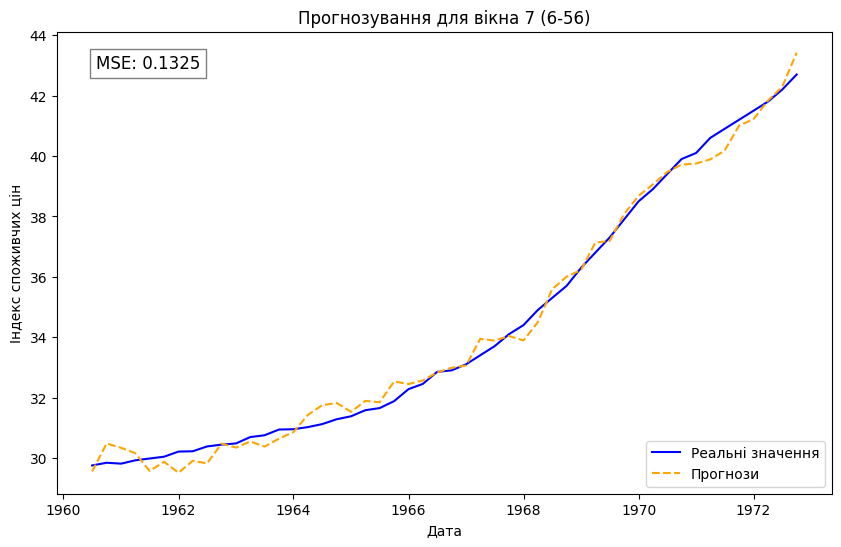

Training on window 8 (7-57)
Generation 0: Best fitness = -0.13380537259184744
Generation 100: Best fitness = -0.13221596533180485
Generation 200: Best fitness = -0.13159570698201975
Generation 300: Best fitness = -0.1305185242510607
Generation 400: Best fitness = -0.1305185242510607
Generation 500: Best fitness = -0.1305185242510607
Generation 600: Best fitness = -0.12856576028587227
Generation 700: Best fitness = -0.12727605185570934
Generation 800: Best fitness = -0.1240715975083821
Generation 900: Best fitness = -0.12112091489759592


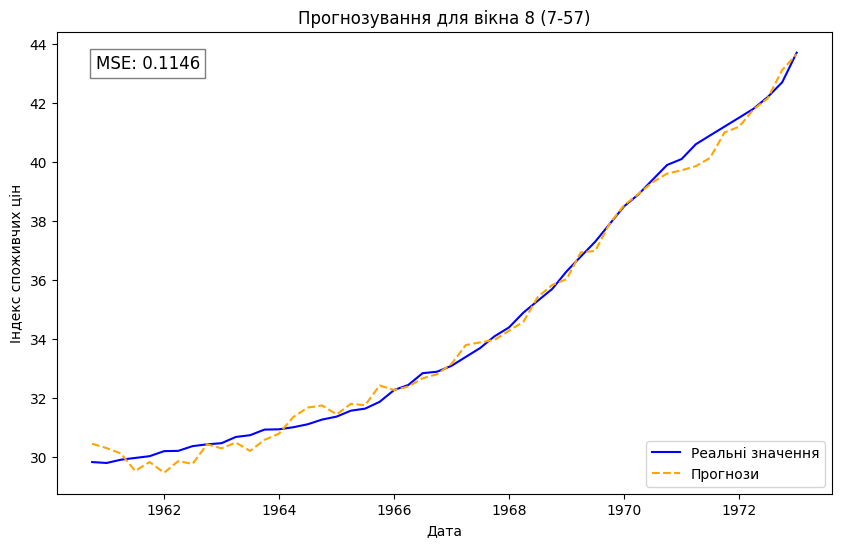

Training on window 9 (8-58)
Generation 0: Best fitness = -0.12913912880570863
Generation 100: Best fitness = -0.11350929527078037
Generation 200: Best fitness = -0.10962921522478553
Generation 300: Best fitness = -0.10962921522478553
Generation 400: Best fitness = -0.10962921522478553
Generation 500: Best fitness = -0.10954359434069538
Generation 600: Best fitness = -0.10825427928882535
Generation 700: Best fitness = -0.1078719397318689
Generation 800: Best fitness = -0.10702454336261433
Generation 900: Best fitness = -0.1069983686717989


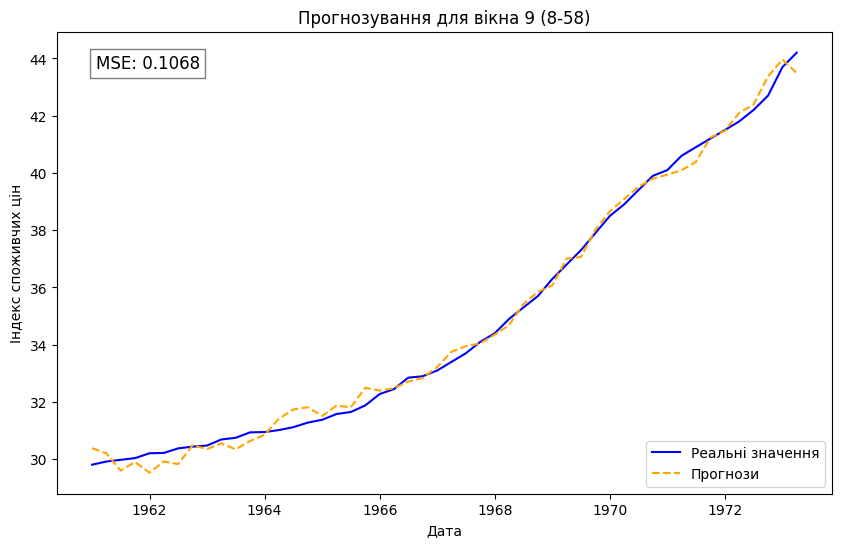

Training on window 10 (9-59)
Generation 0: Best fitness = -0.18660364519066186
Generation 100: Best fitness = -0.1584722939331768
Generation 200: Best fitness = -0.1498568017916115
Generation 300: Best fitness = -0.14806731767799441
Generation 400: Best fitness = -0.1474540244283714
Generation 500: Best fitness = -0.14553371742290797
Generation 600: Best fitness = -0.14553371742290797
Generation 700: Best fitness = -0.14522095763382048
Generation 800: Best fitness = -0.14475431294660154
Generation 900: Best fitness = -0.14475431294660154


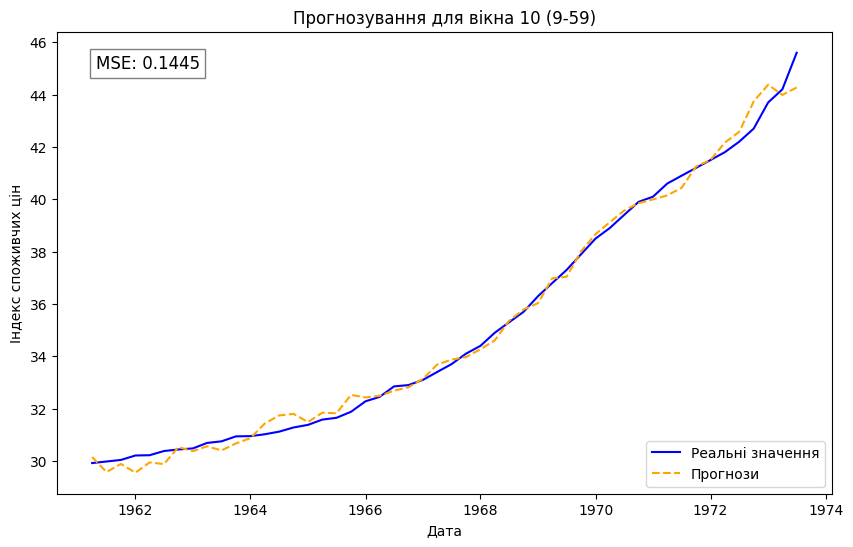

In [36]:
X_scaled = scaler.fit_transform(X_part)

# Створення моделі
model = NeuralNetwork(X_part.shape[1])
model.add_layer(DenseLayer(num_inputs=X_part.shape[1], num_neurons=8, activation_func=ReLU()))
model.add_layer(DenseLayer(num_inputs=8, num_neurons=1, activation_func=ReLU()))

# Налаштування оптимізатора
optimizer = GeneticOptimizer(population_size=50, mutation_rate=0.1)

sliding_window_training(X_scaled, y_part, "partial", window_size=50, num_windows=10)
